## Beware
This is code from wayy after the paper was submited. I going back and revisting this topic. 
- Khizr Ali Pardhan 

In [1]:
# Import required Libraries
# !pip install fastparquet
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
stocks = pd.read_parquet('https://github.com/ddkpham/Stock_Prediction_NLP_ML/blob/master/wsb.hourly.joined.parquet.gz?raw=true')

In [3]:
stocks = stocks.set_index('created_utc')
stocks.head(5)

,score,gilded,wordcount,0,1,2,3,4,5,6,...,20,21,22,23,24,AAPL_StockPrice,AMZN_StockPrice,BA_StockPrice,SPY_StockPrice,TSLA_StockPrice
created_utc,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,10.600000,0.0,15.127273,-0.004773,0.096914,-0.028997,-0.013654,-0.040472,-0.028197,0.125876,...,0.034497,0.012236,0.022241,0.046725,-0.052190,116.01,757.76,155.68,224.86,214.3
2017-01-03 01:00:00,6.126761,0.0,14.957746,-0.018255,0.086793,-0.015693,-0.014463,-0.047337,-0.039189,0.151025,...,0.004107,0.018103,0.037762,0.030239,-0.058607,116.01,757.76,155.68,224.86,214.3
2017-01-03 02:00:00,5.150685,0.0,18.753425,-0.013361,0.085355,-0.045373,-0.029794,-0.013735,-0.030920,0.150325,...,-0.003617,0.002007,0.037377,0.017159,-0.064736,116.01,757.76,155.68,224.86,214.3
2017-01-03 03:00:00,5.723404,0.0,16.893617,-0.008933,0.079429,-0.009839,-0.026562,-0.041718,-0.015318,0.154539,...,-0.007581,0.005232,0.022578,0.016312,-0.054883,116.01,757.76,155.68,224.86,214.3
2017-01-03 04:00:00,1.516667,0.0,19.700000,-0.015290,0.079454,-0.002097,-0.019933,-0.023108,-0.015315,0.154939,...,-0.011684,0.011437,0.028106,0.017372,-0.061380,116.01,757.76,155.68,224.86,214.3


In [4]:
dataset = stocks.values
dataset.shape
dataset[0]

(17022, 33)

array([ 1.06000000e+01,  0.00000000e+00,  1.51272727e+01, -4.77294810e-03,
        9.69139859e-02, -2.89973784e-02, -1.36540728e-02, -4.04721014e-02,
       -2.81969681e-02,  1.25875890e-01, -9.05721411e-02, -1.96984317e-02,
        1.46932453e-02, -5.44711426e-02,  6.78111836e-02, -6.44198656e-01,
       -2.55610738e-02,  5.78277409e-02,  2.39723418e-02,  5.06082103e-02,
       -3.92869785e-02, -5.36252372e-03, -8.66491627e-03,  3.44966017e-02,
        1.22362645e-02,  2.22405102e-02,  4.67252582e-02, -5.21895476e-02,
        1.16010000e+02,  7.57760000e+02,  1.55680000e+02,  2.24860000e+02,
        2.14300000e+02])

In [5]:
price_data = stocks.filter(['SPY_StockPrice']) # ['AAPL_StockPrice', 'AMZN_StockPrice', 'BA_StockPrice', 'SPY_StockPrice', 'TSLA_StockPrice']
price_dataset = price_data.values
price_dataset

array([[224.86],
       [224.86],
       [224.86],
       ...,
       [303.33],
       [303.33],
       [303.33]])

In [6]:
# set training set len
training_data_len = math.ceil(len(dataset) * 0.8)

In [7]:
# Scale datasets 
scaler = MinMaxScaler(feature_range=(-1,1))
price_scaler = MinMaxScaler(feature_range=(-1,1))

scaled_dataset = scaler.fit_transform(dataset)
scaled_price_dataset = price_scaler.fit_transform(price_dataset)

In [8]:
# Split data into x_train, y_train 
train_features = np.array(scaled_dataset[0:training_data_len,:])
train_values = np.array(scaled_price_dataset[0:training_data_len, :])
x_train = []
y_train = []
for i in range(60, len(train_features)):
  x_train.append(train_features[i-60:i, :])
  y_train.append(train_values[i:i+1, :][0].tolist())
#   if(i < 62):
#     print(y_train)

# Convert both x, y training sets to np array 
x_train, y_train = np.array(x_train), np.array(y_train)
# print(y_train, type(y_train))

# Reshape the data // LSTM network expects 3 dimensional input in the form of 
# (number of samples, number of timesteps, number of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 33))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))

x_train.shape
y_train.shape

(13558, 60, 33)

(13558, 1)

In [9]:
test_data = scaled_dataset[training_data_len-60:, :]
test_y = scaled_price_dataset[training_data_len-60:, :]

x_test = []
y_test = []

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, :])
  y_test.append(test_y[i:i+1, :][0].tolist())
    
# Convert the data into a np array
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape data into 3 dimensions ( num samples, timesteps, num features )
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 33))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

x_test.shape
y_test.shape

(3404, 60, 33)

(3404, 1)

In [10]:
# x_train.shape
# y_train.shape
# numb_itr = x_train.shape[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# x_train = torch.FloatTensor(x_train).to(device)
# y_train = torch.FloatTensor(y_train).to(device)
# x_train.size()
# y_train.size()

# x_test = torch.FloatTensor(x_test).to(device)
# y_test = torch.FloatTensor(y_test).to(device)
batch_size = 16
train = torch.utils.data.TensorDataset(torch.FloatTensor(x_train).to(device), torch.FloatTensor(y_train).to(device))
test = torch.utils.data.TensorDataset(torch.FloatTensor(x_test).to(device), torch.FloatTensor(y_test).to(device))

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
class LSTM(nn.Module):
    def __init__(self, batch_size, input_dim=100, hidden_dim=50, tagset_size=5):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size
        self.batch_size = batch_size

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_1 = nn.LSTM(input_dim, hidden_dim, bidirectional=True)
        self.dense_bridge = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.lstm_2 = nn.LSTM(hidden_dim*2, hidden_dim, bidirectional=False)
        self.dense_1 = nn.Linear(hidden_dim, tagset_size)
        self.dropOut = nn.Dropout(p=0.4)
        self.layerNorm_1 = nn.LayerNorm(hidden_dim*2)
        self.layerNorm_2 = nn.LayerNorm(hidden_dim)

    def forward(self, input_data):
        
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
#         print((len(input_data), self.batch_size))
#         x = input_data.view(len(input_data), self.batch_size)
        x, _ = self.lstm_1(input_data) # if i dont zero out `_`, the LSTM is stateful 
        x = self.layerNorm_1(self.dropOut(x)) 
        
        x = self.dense_bridge(x) # is Keras, this helps, IDK about pyTorch
        x, _ = self.lstm_2(x)
        
        x = self.layerNorm_2(self.dropOut(x)) 
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        x = self.dense_1(x[:, -1, :]) #.view(self.batch_size, -1))
        return x
        
        
#         x, _ = self.lstm_1(input_data)
#         x = self.dropout(x)
#         x = self.dense_bridge(x)
#         x, _ = self.lstm_2(x)
#         x = self.dropout(x)
#         x = self.dense_1(x[:, :, :])
#         return x

In [12]:
model = LSTM(input_dim=x_train.shape[2], hidden_dim=25, tagset_size=y_train.shape[1], batch_size=batch_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

for k in model.state_dict():
    print(f'Item: {k} \t\t|Size {model.state_dict()[k].size()}')

Item: lstm_1.weight_ih_l0 		|Size torch.Size([100, 33])
Item: lstm_1.weight_hh_l0 		|Size torch.Size([100, 25])
Item: lstm_1.bias_ih_l0 		|Size torch.Size([100])
Item: lstm_1.bias_hh_l0 		|Size torch.Size([100])
Item: lstm_1.weight_ih_l0_reverse 		|Size torch.Size([100, 33])
Item: lstm_1.weight_hh_l0_reverse 		|Size torch.Size([100, 25])
Item: lstm_1.bias_ih_l0_reverse 		|Size torch.Size([100])
Item: lstm_1.bias_hh_l0_reverse 		|Size torch.Size([100])
Item: dense_bridge.weight 		|Size torch.Size([50, 50])
Item: dense_bridge.bias 		|Size torch.Size([50])
Item: lstm_2.weight_ih_l0 		|Size torch.Size([100, 50])
Item: lstm_2.weight_hh_l0 		|Size torch.Size([100, 25])
Item: lstm_2.bias_ih_l0 		|Size torch.Size([100])
Item: lstm_2.bias_hh_l0 		|Size torch.Size([100])
Item: dense_1.weight 		|Size torch.Size([1, 25])
Item: dense_1.bias 		|Size torch.Size([1])
Item: layerNorm_1.weight 		|Size torch.Size([50])
Item: layerNorm_1.bias 		|Size torch.Size([50])
Item: layerNorm_2.weight 		|Size torch

In [13]:
# weights = model.state_dict('./tmp')
PATH = './torch_model_5_outputs.h5'
# torch.save(model, PATH)
# model.load_state_dict(torch.load(PATH))

In [15]:
num_epochs = 2 #85
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    mse = 0
    
    if epoch == 5:
        optimizer.param_groups[0]['lr'] = 0.001
    if epoch == 75:
        optimizer.param_groups[0]['lr'] = 0.00025

    for x, y in train_loader:

        
        # Clear stored gradient
        model.zero_grad()

        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        # model.hidden = model.init_hidden()

        # Forward pass
        y_pred = model(x)
        
#         print(y.size())
#         print(y_pred.size())
        
#         assert y.size() == y_pred.size()
        
        loss = loss_function(y_pred, y)
        mse += loss.item()
        hist[epoch] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()
        
        # Clip Grads
        clipping_value = 2 # arbitrary value of your choosing
        _ = torch.nn.utils.clip_grad_value_(model.parameters(), clipping_value) # CLIP_GRAD_VALUE_
#         for p in model.parameters():
#             _ = p.grad.data.clamp_(max=clipping_value)

        # Update parameters
        optimizer.step()

    with torch.no_grad():
        test_mse = 0 
        for x, y in test_loader:
            y_pred_batch = model(x)
            loss = loss_function(y_pred_batch, y)
            test_mse += loss.item()

    print(f'Epoch: {epoch+1}/{num_epochs} | MSE: {mse:.2f} | [Test] MSE: {test_mse:.2f} ')


Epoch: 1/2 | MSE: 13.98 | [Test] MSE: 15.60 
Epoch: 2/2 | MSE: 38.17 | [Test] MSE: 13.24 


In [16]:
# See what the scores are after training

y_pred = []
with torch.no_grad():
    mse = 0 
    for x, y in test_loader:
        y_pred_batch = model(x)
        y_pred.extend(y_pred_batch.tolist())
        loss = loss_function(y_pred_batch, y)
        mse += loss.item()
    print(f'MSE: {mse:.2f}')

MSE: 13.16


In [17]:
y_pred_ = price_scaler.inverse_transform(y_pred) # .reshape(-1, 1)
y_test_ = price_scaler.inverse_transform(y_test) # .reshape(-1, 1)

y_pred_.shape
y_test_.shape

(3404, 1)

(3404, 1)

In [18]:
mae = np.mean(np.abs(y_pred_-y_test_))

rmse = np.sqrt(np.mean((y_pred_-y_test_)**2))
mse = np.mean((y_pred_-y_test_)**2)

mape = np.mean(np.abs((y_pred_ - y_test_) / y_pred_)) * 100
mspe = np.mean(((y_pred_ - y_test_) / y_pred_)**2) * 100 # i hope this is correct

print(f'MAE: {mae:.2f} | MSE: {mse:.2f} | rMSE: {rmse:.2f} | MAPE: {mape:.2f} | MSPE: {mspe:.2f}')

MAE: 8.52 | MSE: 100.43 | rMSE: 10.02 | MAPE: 2.99 | MSPE: 0.12


In [24]:
# # Set up ploting dataset
# # plotData = stocks.filter(['created_utc','AAPL_CPrc', 'AMZN_CPrc', 'BA_CPrc', 'SPY_CPrc', 'TSLA_CPrc'])
# # plotData = plotData.set_index("created_utc")
# # print(plotData, type(plotData))
y_pred_NLP = y_pred_
SPY = stocks["SPY_StockPrice"]
SPY = SPY.to_frame();
spyTest = SPY[0: training_data_len]
spyValid = SPY[training_data_len:]
spyValid
# # This is so it graphs nicely with dates 
# AAPL = stocks["AAPL_StockPrice"]
# AAPL = AAPL.to_frame()
# AMZN = stocks["AMZN_StockPrice"]
# AMZN = AMZN.to_frame()
# BA = stocks["BA_StockPrice"]
# BA = BA.to_frame();

# TSLA = stocks["TSLA_StockPrice"]
# TSLA = TSLA.to_frame()

# appleTest = AAPL[0:training_data_len]
# amazonTest = AMZN[0:training_data_len]
# boeTest = BA[0:training_data_len]
# teslaTest = TSLA[0: training_data_len]

# appleValid = AAPL[training_data_len:]
# amazonValid = AMZN[training_data_len:]
# boeValid = BA[training_data_len:]
# teslaValid = TSLA[training_data_len:]
# # print(appleValid)

# appleValid['Predictions'] = predictions[:,:1]
# amazonValid["Predictions"] = predictions[:,1:2]
# boeValid['Predictions'] = predictions[:, 2:3]
# spyValid["Predictions"] = predictions[:, 3:4]
# teslaValid["Predictions"] = predictions[:, 4:5]
# print(len(appleValid), len(predictions)) # 3404 3404

,SPY_StockPrice
created_utc,
2019-04-11 04:00:00,288.39
2019-04-11 05:00:00,288.69
2019-04-11 06:00:00,288.86
2019-04-11 07:00:00,288.77
2019-04-11 08:00:00,288.62
...,...
2019-10-31 19:00:00,303.20
2019-10-31 20:00:00,303.33
2019-10-31 21:00:00,303.33


## If 5 outputs, 

In [20]:
# # Visualize data
# _ = plt.figure(figsize=(16,8))
# _ = plt.title('Prediction with reddit glove vectors')
# _ = plt.xlabel('Date', fontsize=18)
# _ = plt.ylabel('Close Price USD ($)', fontsize=18)

# # plt.plot(appleTest)
# # plt.plot(appleValid['AAPL_StockPrice'])
# # plt.plot(appleValid['Predictions'])
# # plt.plot(amazonTest)
# # plt.plot(amazonValid['AMZN_StockPrice'])
# # plt.plot(amazonValid['Predictions'])
# # plt.plot(boeTest)
# # plt.plot(boeValid['BA_StockPrice'])
# # plt.plot(boeValid['Predictions'])

# _ = plt.plot(spyTest)
# _ = plt.plot(spyValid['SPY_StockPrice'])
# # _ = plt.plot(spyValid['Predictions'])
# _ = plt.plot(spyValid['Predictions'].rolling(window=10).mean())


# # plt.plot(teslaTest)
# # plt.plot(teslaValid['TSLA_StockPrice'])
# # plt.plot(teslaValid['Predictions'])
# _ = plt.legend(['Train', 'Validation', 'Prediction'])
# _ = plt.show()

## If 1 output,

c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


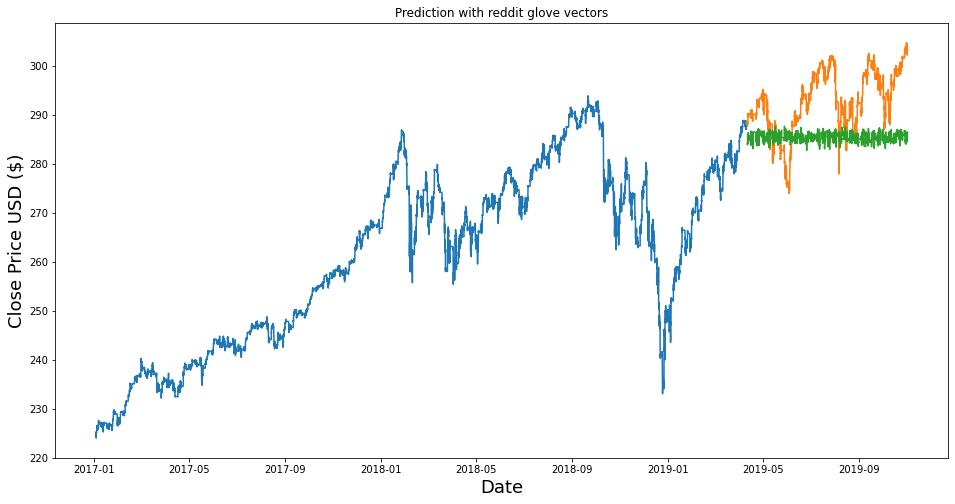

In [26]:
spyValid['Predictions'] = y_pred_NLP.flatten()
_ = plt.figure(figsize=(16,8))
_ = plt.title('Prediction with reddit glove vectors')
_ = plt.xlabel('Date', fontsize=18)
_ = plt.ylabel('Close Price USD ($)', fontsize=18)

_ = plt.plot(spyTest)
_ = plt.plot(spyValid['SPY_StockPrice'])
# _ = plt.plot(spyValid['Predictions'])
_ = plt.plot(spyValid['Predictions'].rolling(window=10).mean())

In [27]:
hourly_prices = stocks.filter(['AAPL_StockPrice', 'AMZN_StockPrice', 'BA_StockPrice', 'SPY_StockPrice', 'TSLA_StockPrice'])
hourly_prices.shape

# set training set len
train_len = math.ceil(len(hourly_prices) * 0.80) 

(17022, 5)

In [28]:
hourScaler = MinMaxScaler(feature_range=(-1, 1))
scaled_x = hourScaler.fit_transform(hourly_prices)
scaled_y = hourScaler.fit_transform(stocks.filter(['SPY_StockPrice']))

x_train_data = scaled_x[0:train_len, :]
y_train_data = scaled_y[0:train_len, :]

x_test_data = scaled_x[training_data_len-60:, :]
y_test_data = scaled_y[training_data_len-60:, :]

In [29]:
x_train2 = []
y_train2 = []

for i in range(60, len(x_train_data)):
  x_train2.append(x_train_data[i-60:i, :])
  y_train2.append(y_train_data[i:i+1, :][0].tolist())

x_train2, y_train2 = np.array(x_train2), np.array(y_train2)
# (number of samples, number of timesteps, number of features)
x_train2 = np.reshape(x_train2, (x_train2.shape[0], x_train2.shape[1], 5))

print(f'x_train2.shape: {x_train2.shape}')
print(f'y_train2.shape: {y_train2.shape}')

x_train2.shape: (13558, 60, 5)
y_train2.shape: (13558, 1)


In [30]:
x_test2 = []
y_test2 = []

for i in range(60, len(test_data)):
  x_test2.append(x_test_data[i-60: i, :])
  y_test2.append(y_test_data[i:i+1, :][0].tolist())
    
x_test2, y_test2 = np.array(x_test2), np.array(y_test2)

# Reshape data into 3 dimensions ( num samples, timesteps, num features )
x_test2 = np.reshape(x_test2, (x_test2.shape[0], x_test2.shape[1], 5))

print(f'x_test2.shape:  {x_test2.shape}')
print(f'y_test2.shape:  {y_test2.shape}')

x_test2.shape:  (3404, 60, 5)
y_test2.shape:  (3404, 1)


In [31]:
batch_size = 16
train2 = torch.utils.data.TensorDataset(torch.FloatTensor(x_train2).to(device), torch.FloatTensor(y_train2).to(device))
test2 = torch.utils.data.TensorDataset(torch.FloatTensor(x_test2).to(device), torch.FloatTensor(y_test2).to(device))

train_loader2 = torch.utils.data.DataLoader(dataset=train2, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader2 = torch.utils.data.DataLoader(dataset=test2, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [32]:
model2 = LSTM(input_dim=x_train2.shape[2], hidden_dim=25, tagset_size=y_train2.shape[1], batch_size=batch_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


for k in model2.state_dict():
    print(f'Item: {k} \t\t|Size {model.state_dict()[k].size()}')

Item: lstm_1.weight_ih_l0 		|Size torch.Size([100, 33])
Item: lstm_1.weight_hh_l0 		|Size torch.Size([100, 25])
Item: lstm_1.bias_ih_l0 		|Size torch.Size([100])
Item: lstm_1.bias_hh_l0 		|Size torch.Size([100])
Item: lstm_1.weight_ih_l0_reverse 		|Size torch.Size([100, 33])
Item: lstm_1.weight_hh_l0_reverse 		|Size torch.Size([100, 25])
Item: lstm_1.bias_ih_l0_reverse 		|Size torch.Size([100])
Item: lstm_1.bias_hh_l0_reverse 		|Size torch.Size([100])
Item: dense_bridge.weight 		|Size torch.Size([50, 50])
Item: dense_bridge.bias 		|Size torch.Size([50])
Item: lstm_2.weight_ih_l0 		|Size torch.Size([100, 50])
Item: lstm_2.weight_hh_l0 		|Size torch.Size([100, 25])
Item: lstm_2.bias_ih_l0 		|Size torch.Size([100])
Item: lstm_2.bias_hh_l0 		|Size torch.Size([100])
Item: dense_1.weight 		|Size torch.Size([1, 25])
Item: dense_1.bias 		|Size torch.Size([1])
Item: layerNorm_1.weight 		|Size torch.Size([50])
Item: layerNorm_1.bias 		|Size torch.Size([50])
Item: layerNorm_2.weight 		|Size torch

In [33]:
num_epochs = 2 # 85
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    mse = 0
    
    if epoch == 5:
        optimizer.param_groups[0]['lr'] = 0.001
    if epoch == 75:
        optimizer.param_groups[0]['lr'] = 0.00025

    for x, y in train_loader2:

        
        # Clear stored gradient
        model2.zero_grad()

        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        # model.hidden = model.init_hidden()

        # Forward pass
        y_pred = model2(x)
        
#         print(y.size())
#         print(y_pred.size())
        
#         assert y.size() == y_pred.size()
        
        loss = loss_function(y_pred, y)
        mse += loss.item()
        hist[epoch] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()
        
        # Clip Grads
        clipping_value = 2 # arbitrary value of your choosing
        _ = torch.nn.utils.clip_grad_value_(model.parameters(), clipping_value) # CLIP_GRAD_VALUE_
#         for p in model.parameters():
#             _ = p.grad.data.clamp_(max=clipping_value)

        # Update parameters
        optimizer.step()

    with torch.no_grad():
        test_mse = 0 
        for x, y in test_loader2:
            y_pred_batch = model2(x)
            loss = loss_function(y_pred_batch, y)
            test_mse += loss.item()

    print(f'Epoch: {epoch+1}/{num_epochs} | MSE: {mse:.2f} | [Test] MSE: {test_mse:.2f} ')

Epoch: 1/2 | MSE: 536.41 | [Test] MSE: 267.18 
Epoch: 2/2 | MSE: 533.09 | [Test] MSE: 267.65 


In [34]:
# See what the scores are after training
y_pred = []
with torch.no_grad():
    mse = 0 
    for x, y in test_loader2:
        y_pred_batch = model2(x)
        y_pred.extend(y_pred_batch.tolist())
        loss = loss_function(y_pred_batch, y)
        mse += loss.item()
    print(f'MSE: {mse:.2f}')

MSE: 253.52


In [35]:
y_pred_ = price_scaler.inverse_transform(y_pred) # .reshape(-1, 1)
y_test_ = price_scaler.inverse_transform(y_test) # .reshape(-1, 1)

y_pred_.shape
y_test_.shape

(3404, 1)

(3404, 1)

In [36]:
mae = np.mean(np.abs(y_pred_ - y_test_))
mse = np.mean(np.power(y_pred_ - y_test_, 2))
rmse = np.sqrt(mse)

mape = np.mean(np.abs((y_pred_ - y_test_) / y_pred_)) * 100
mspe = np.mean(np.power(y_pred_ - y_test_, 2)) * 100 # I hope this is correct

print(f'MAE: {mae:.2f} | MSE: {mse:.2f} | rMSE: {rmse:.2f} | MAPE: {mape:.2f} | MSPE: {mspe:.2f}')

MAE: 39.28 | MSE: 1937.92 | rMSE: 44.02 | MAPE: 16.12 | MSPE: 193791.61


c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='created_utc'>

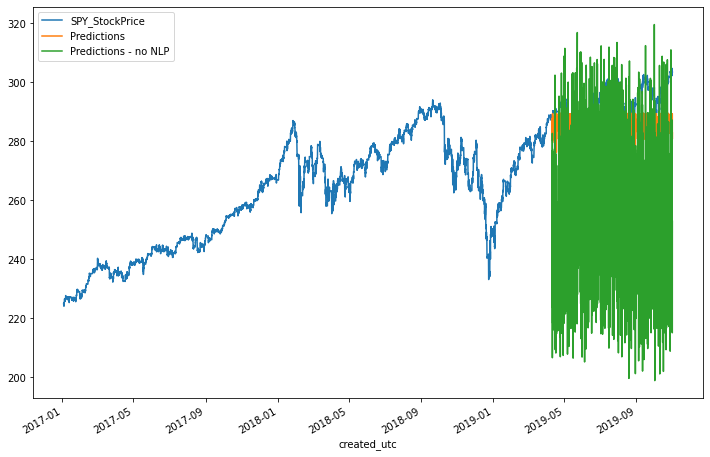

In [37]:
# spyTest # train 
# spyValid # test 
spyValid.loc[:,'Predictions'] = y_pred_NLP.flatten()
spyValid.loc[:,'Predictions - no NLP'] = y_pred_.flatten()
pd.concat([spyTest, spyValid]).plot(figsize=(12,8))

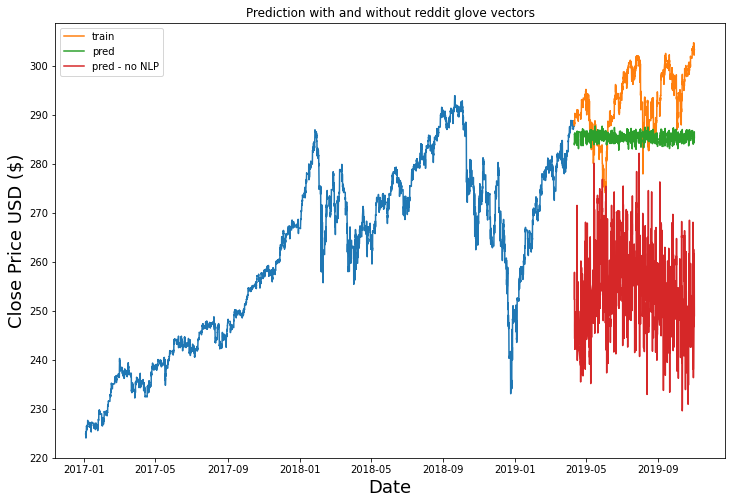

In [38]:
_ = plt.figure(figsize=(12,8))
_ = plt.title('Prediction with and without reddit glove vectors')
_ = plt.xlabel('Date', fontsize=18)
_ = plt.ylabel('Close Price USD ($)', fontsize=18)

_ = plt.plot(spyTest)
_ = plt.plot(spyValid['SPY_StockPrice'], label="train")
_ = plt.plot(spyValid['Predictions'].rolling(window=10).mean(), label="pred")
_ = plt.plot(spyValid['Predictions - no NLP'].rolling(window=10).mean(), label="pred - no NLP")
_ = plt.legend()

In [39]:
# print(len(appleValid)) # 3404
# appleValid['Predictions2'] = predictions2[:,:1]
# amazonValid["Predictions2"] = predictions2[:,1:2]
# boeValid['Predictions2'] = predictions2[:, 2:3]
# spyValid["Predictions2"] = predictions2[:, 3:4]
# teslaValid["Predictions2"] = predictions2[:, 4:5]

In [ ]:
# # Visualize data
# plt.figure(figsize=(16,8))
# plt.title('Stock Prediction with and without Reddit word vector data \n (AAPL)')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(appleTest)
# plt.plot(appleValid)
# plt.plot(appleValid['Predictions'], color='red')
# plt.plot(appleValid['Predictions2'], color='green')
# # plt.plot(amazonTest)
# # plt.plot(amazonValid)
# # plt.plot(amazonValid['Predictions'], color='red')
# # plt.plot(amazonValid['Predictions2'], color='green')
# # plt.plot(boeTest)
# # plt.plot(boeValid)
# # plt.plot(boeValid['Predictions'], color='red')
# # plt.plot(boeValid['Predictions2'], color='green')
# # plt.plot(spyTest, label='Train')
# # plt.plot(spyValid, label='Actual')
# # plt.plot(spyValid['Predictions'], label='Prediction with vector', color='red')
# # plt.plot(spyValid['Predictions2'], label='Prediction without vector', color='green')

# # plt.plot(teslaTest, label='Train')
# # plt.plot(teslaValid, label="Actual")
# # plt.plot(teslaValid['Predictions'], label="vector prediction", color='red')
# # plt.plot(teslaValid['Predictions2'], label="without vector prediction", color="green")
# plt.legend(('Train', 'Validation', 'Prediction with vector', 'Prediction without'), title="Legend",)
# plt.show()


In [ ]:
# for i in range(0, len(x_train) - (len(x_train)%batch_size), batch_size):


# for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
#     mse = 0
#     for i in range(0, len(x_train) - (len(x_train)%batch_size), batch_size):

#         # Step 1. Remember that Pytorch accumulates gradients.
#         # We need to clear them out before each instance
#         model.zero_grad()

#         # Step 2. Get our inputs ready for the network, that is, turn them into
#         # Tensors of word indices.
        
# #         print(type(y_train[i:i+16]))
# #         break

#         # Step 3. Run our forward pass.
#         output = model(x_train[i:i+batch_size])

#         # Step 4. Compute the loss, gradients, and update the parameters by
#         #  calling optimizer.step()
#         loss = loss_function(output, y_train[i:i+batch_size])
#         loss.backward()
#         optimizer.step()
#         mse += loss
# #         print(loss)
#     print(f'Epoch: {epoch+1}/{epochs} | Loss: {mse}')